# Module 2: Data Analysis
## Sprint 2: Inferential Statistical Analysis
## Part 5: Inferential Statistical Analysis of the Podcast Reviews


## About this Part

Congrats!
You have reached the last Part of this Sprint.
In this Part, you will put what you learned during this and the previous Sprints into practice.
As the final assignment of this Sprint, you will analyse the Podcast Reviews Dataset.
You will have to apply all that you have learned about Statistical Inference & SQL to complete this task.
Our expectation is that you'll use your own judgement how to perform the analysis and how to select the most important avenues of statistical testing and exploration.
You'll have to iteratively raise hypotheses and use your data analysis skills to get answers.

## Objectives for this Part

- Practice working with SQLite datasets.
- Practice performing EDA.
- Practice applying statistical inference procedures.
- Practice visualizing data with Matplotlib & Seaborn.
- Practice reading data, performing queries and filtering data using SQL and Pandas.

## Requirements

- Download the data from [Podcast Reviews Dataset](https://www.kaggle.com/thoughtvector/podcastreviews).
- Load the data using SQLite and Pandas.
- Perform exploratory data analysis. This should include creating statistical summaries and charts, testing for anomalies, checking for correlations and other relations between variables, and other EDA elements.
- Perform statistical inference. This should include defining the target population, forming multiple statistical hypotheses and constructing confidence intervals, setting the significance levels, conducting z or t-tests for these hypotheses.
- Provide clear explanations in your notebook. Your explanations should inform the reader what you are trying to achieve, what results did you get, and what these results mean.
- Provide suggestions about how your analysis can be improved.

## Evaluation Criteria

- Adherence to the requirements. How well did you meet the requirements?
- Depth of your analysis. Did you just skim the surface or did you explored the dataset in depth?
- Visualization quality. Did you use charts effectively to visualize patterns in the data? Are your visualizations properly labeled? Did you use colors effectively? Did you adhere to the principle of proportional ink?
- Code quality. Was your code well-structure? Did you use the appropriate levels of abstraction? Did you remove commented out and unused code? Did you adhere to the PEP8?
- Code performance. Did you use the suitable algorithms and data structures to solve the problems?

## Sample Correction Questions

During a correction, you may get asked questions that test your understanding of covered topics.

- Explain how to perform a permutation procedure
- What is the difference between a parameter and a statistic?
- What is a confidence interval?
- Why is it risky to assume a normal distribution?
- Why do we need to have control groups, while doing A/B testing?



# Imports

In [2]:
pip install statsmodels==0.13.0

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from seaborn.palettes import color_palette
from collections import Counter
import math
import numpy as np
import statsmodels.stats.weightstats as sm
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
import warnings
from typing import Dict, List
from typing import TypeVar

PandasDataFrame = TypeVar("pandas.core.frame.DataFrame")
AxesSubplot = TypeVar("matplotlib.axes._subplots.AxesSubplot")

warnings.filterwarnings("ignore")

In [4]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette('summer')

In [5]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
conn = sql.connect("/content/drive/MyDrive/podcast_dataset/database.sqlite")

# Functions

In [7]:
def drop_outliers(dataframe: PandasDataFrame) -> PandasDataFrame:
    """This function replaces the outlier values of a provided dataframe with 
    NaN values. """
    for column in dataframe.select_dtypes(np.number).columns:
        q1 = dataframe[column].quantile(0.25)  # 1st quartile value
        q3 = dataframe[column].quantile(0.75)  # 3rd quartile value
        iqr = q3 - q1  # Interquartile range
        outlier = (dataframe[column] < (q1 - 1.5 * iqr)) | (
            dataframe[column] > (q3 + 1.5 * iqr)
        )

        # mask outliers with nan values
        dataframe[column].mask(outlier, other=np.nan, inplace=True)

    return dataframe

In [8]:
def plot_labels(title: str, x_label=None, y_label=None):
    """This function sets the title and axes labels for a given plot."""
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [9]:
def plot_axes(l_spine=False, r_spine=False, top_spine=False, bottom_spine=True, x_visible=False, y_visible=True):
    """This function sets visibility of the plots axes and spines."""
    plt.grid(visible=x_visible, axis='x')
    plt.grid(visible=y_visible, axis='y')
    ax.spines['right'].set_visible(r_spine)
    ax.spines['top'].set_visible(top_spine)
    ax.spines['left'].set_visible(l_spine)
    ax.spines['bottom'].set_visible(bottom_spine)

In [10]:
def show_values(axs: AxesSubplot, orient: str='v', space: float=0.05, decimals: int=1):
    """ This function adds value labels to the plot provided. The default plot
    orientation is vertical. To change it to horizontal pass orient='h'. The 
    space parameter can be changed to control the position of the labels. The 
    decimals parameter defines how many decimals are shown."""
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + float(space)
                value = '{:.{}f}'.format(p.get_height(), decimals)
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.2)
                value = '{:.{}f}'.format(p.get_width(), decimals)
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [11]:
def unpooled_ci(x1: PandasDataFrame, x2: PandasDataFrame, best_estimate: float, tstar=1.96):
    """ The function calculates the confidence interval for the best estimate
    of the difference in means provided."""
    var_1 = x1.std()**2
    var_2 = x2.std()**2
    sample_size_1 = x1.count()
    sample_size_2 = x2.count()
    estimated_standard_error = math.sqrt((var_1 / sample_size_1) + (var_2 / sample_size_2))
    margin = tstar * estimated_standard_error
    lower_bound = best_estimate - tstar * estimated_standard_error
    upper_bound = best_estimate + tstar * estimated_standard_error

    return best_estimate, margin, lower_bound, upper_bound

# EDA

## Overview of the database

In [12]:
categories = pd.read_sql('select * from categories', conn)
categories.head()

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts-design


In [13]:
podcast_count = pd.read_sql('select count(distinct podcast_id) as pod_count from categories', conn)['pod_count'][0]
podcast_count

46693

The _Categories_ table contains information about categories assigned to 46 693 podcast IDs.

In [14]:
categories_grouped = pd.read_sql('select category, count(podcast_id) as total_count from categories group by category', conn)
len(categories_grouped)

26

In [15]:
categories_grouped.nlargest(5, 'total_count')

,category,total_count
19,society-culture,10073
11,comedy,8080
18,religion-spirituality,7588
7,business,6208
0,arts,5576


In [16]:
categories_grouped.nsmallest(5, 'total_count').sort_values(by=['total_count'], ascending=False)

,category,total_count
2,arts-fashion-beauty,248
15,judaism,148
14,islam,120
6,buddhism,89
13,hinduism,21


Podcasts are grouped into **26 categories**. Most podcasts fall under quite general culture, business and spirituality categories. The subjects of categories with the fewest podcasts are specific smaller religions.

In [17]:
categories_per_podcast = categories.groupby('podcast_id').count()
multiple_categories = categories_per_podcast[categories_per_podcast['category'] > 1]

In [18]:
len(multiple_categories)

18840

In [19]:
'{:.2%}'.format(len(multiple_categories) / len(categories_per_podcast))

'40.35%'

In [20]:
multiple_categories.category.max()

6

Some podcasts are assigned to more than one category. In fact, there are 18 840 such podcasts, which constitutes 40.35% out of the total podcast count. The most categories a podcast is assigned is 6.

In [21]:
category_combos = [frozenset(categories[categories['podcast_id'] == id].category) for id in categories.podcast_id.unique()]

In [22]:
c = Counter(category_combos)
sorted(Counter(el for el in c.elements() if c[el] >= 1000).items(), key=lambda pair: pair[1], reverse=True)

[(frozenset({'comedy'}), 5290),
 (frozenset({'society-culture'}), 4796),
 (frozenset({'christianity', 'religion-spirituality'}), 3729),
 (frozenset({'tv-film'}), 3263),
 (frozenset({'music'}), 3041),
 (frozenset({'education'}), 2829),
 (frozenset({'business'}), 2777),
 (frozenset({'arts'}), 1723),
 (frozenset({'technology'}), 1405),
 (frozenset({'religion-spirituality'}), 1363)]

Category combinations are quite varied (there are a lot of different options) thus the only multiple category combination to be assigned to more than a 1000 podcasts is _christianity_ + _religion-spirituality_.

In [23]:
sorted(Counter(el for el in c.elements() if 1000 > c[el] >= 500).items(), key=lambda pair: pair[1], reverse=True)

[(frozenset({'society-culture', 'society-culture-personal-journals'}), 877),
 (frozenset({'kids-family'}), 857),
 (frozenset({'comedy', 'tv-film'}), 814),
 (frozenset({'business', 'business-careers'}), 698),
 (frozenset({'comedy', 'society-culture'}), 639),
 (frozenset({'religion-spirituality', 'spirituality'}), 541),
 (frozenset({'business', 'education'}), 533)]

When analysing combinations between 500 and 1000 instances, more multi-category combinations occur. The second and the third most common combo are _society-culture_+_society-culture-personal-journals_ and _comedy_+_tv-film_ respectively.

In [24]:
podcasts = pd.read_sql('select * from podcasts', conn)

In [25]:
assert podcast_count == len(podcasts)

In [26]:
podcasts.head()

,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-...,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerst...,Cornerstone Baptist Church of Orlando
2,a0004b1ef445af9dc84dad1e7821b1e3,139076942,mystery-dancing-in-the-dark,https://podcasts.apple.com/us/podcast/mystery-...,Mystery: Dancing in the Dark
3,a00071f9aaae9ac725c3a586701abf4d,1332508972,kts-money-matters,https://podcasts.apple.com/us/podcast/kts-mone...,KTs Money Matters
4,a000aa69852b276565c4f5eb9cdd999b,1342447811,speedway-soccer,https://podcasts.apple.com/us/podcast/speedway...,Speedway Soccer


In [27]:
podcasts.duplicated().any()

False

In [28]:
podcasts.isna().sum()

podcast_id    0
itunes_id     0
slug          0
itunes_url    0
title         0
dtype: int64

The _Podcasts_ table contains information about id, itunes_id, slug, url address and title on 46 693 podcasts (same number as in the _Categories_ table). The table does not contain duplicates or missing values.

In [29]:
reviews = pd.read_sql('select * from reviews', conn)
len(reviews)

1280337

In [30]:
reviews_pod_count = pd.read_sql('select count(distinct podcast_id) as pod_count from reviews', conn)['pod_count'][0]
reviews_pod_count

52986

The _Reviews_ table contains information about 1 280 337 reviews' authors, timestamps, rating, review content and podcast ID. However, it also includes podcast IDs not referenced in the other tables as evident per greater podcast ID count (52 986 vs 46 693).

In [31]:
reviews.duplicated().sum()

637

The table contains 637 duplicate rows.

To access more relevant information, the _Reviews_ and _Podcasts_ tables will be joined, dropping duplicates and keeping only podcast IDs available in all of the tables.

In [32]:
podcast_revs = pd.read_sql('select distinct podcasts.title as podcast_title, reviews.* from reviews left join podcasts on reviews.podcast_id = podcasts.podcast_id', conn).dropna()
podcast_revs.head()

,podcast_title,podcast_id,title,content,rating,author_id,created_at
0,Backstage at Tilles Center,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,Backstage at Tilles Center,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00
2,TED Talks Daily,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00
3,TED Talks Daily,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00
4,TED Talks Daily,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00


In [33]:
len(podcast_revs)

983923

The database contains 983 923 unique reviews on the podcasts in the database.

## Ratings overview

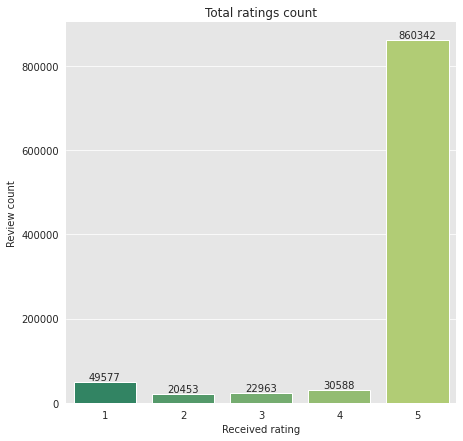

In [34]:
ratings_count = podcast_revs.rating.value_counts()
fig, ax = plt.subplots(figsize=(7,7))
plot_axes()
ratings_count_plot = sns.barplot(x=ratings_count.index, y=ratings_count.values)
show_values(ratings_count_plot, space=5000, decimals=0)
plot_labels('Total ratings count', 'Received rating', 'Review count')
plt.show()

The vast majority (869 342 out of 983 923) of the reviews receive a rating of 5 stars. The 1 star reviews are the second most prominent option chosen.

### Ratings across categories

In [35]:
reviews_categories = podcast_revs.merge(categories, left_on='podcast_id', right_on='podcast_id')
reviews_categories.shape

(1565633, 8)

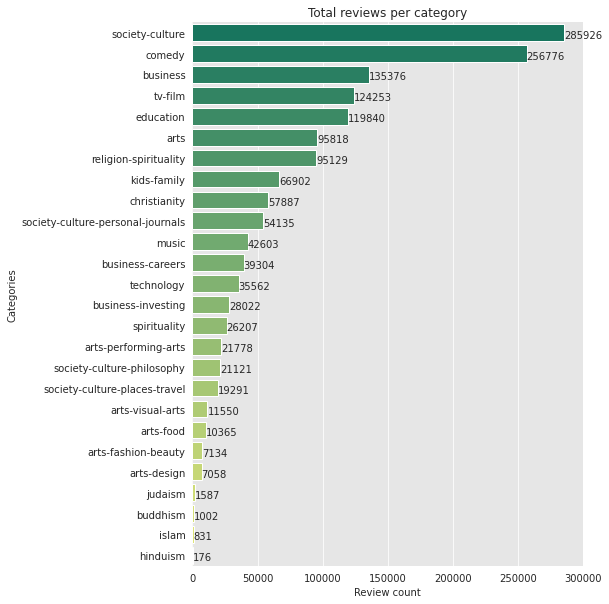

In [36]:
revs_per_category = reviews_categories.category.value_counts()

fig, ax = plt.subplots(figsize=(7,10))
plot_axes(x_visible=True, bottom_spine=False)

revs_per_category_plot = sns.barplot(y=revs_per_category.index, x=revs_per_category.values, palette='summer')
show_values(revs_per_category_plot, orient='h', space=1, decimals=0)
plot_labels('Total reviews per category','Review count', 'Categories')

plt.show()

The plot indicates the top 2 categories to receive the most reviews are society-culture and comedy. The top 5 positions are similar to the total podcast category count, but education and tv-film categories contain less podcasts than arts and religion-spirituality, yet they receive more reviews.

 Similarly, the bottom 5 positions are almost the same, but arts-design category has more podcasts assigned than reviews received compared to arts-fashion-beauty category.

40% of the podcasts are assigned to more than one category, thus when combining review data with categories data, we inevitably get duplicate reviews assigned to different categories.

In [37]:
cat_mean_rating = reviews_categories.groupby('category').mean()['rating'].sort_values(ascending=False)

In [38]:
cat_mean_rating.loc[[cat_mean_rating.idxmax()]].append(cat_mean_rating.loc[[cat_mean_rating.idxmin()]])

category
business-careers    4.886755
tv-film             4.518136
Name: rating, dtype: float64

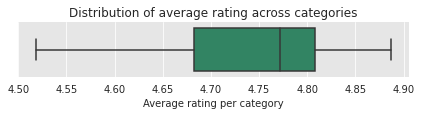

In [39]:
fig, ax = plt.subplots(figsize=(7,1))
plot_axes(x_visible=True)
sns.boxplot(cat_mean_rating)
plot_labels('Distribution of average rating across categories', 'Average rating per category');

*Business-careers* podcasts are best-rated among all of the categories while *tv-film* category receives the worst ratings on average. However, none of the categories receive abnormally better or worst reviews on average. Most categories receive an average rating between 4.6 to 4.8

## Review count overview

In [40]:
podcast_revs.groupby('podcast_id').count()['title'].describe()

count    46693.000000
mean        21.072174
std        123.851899
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max       9171.000000
Name: title, dtype: float64

In [41]:
top_pod = podcast_revs.podcast_title.value_counts().idxmax()

In [42]:
pd.read_sql(f'select categories.category, podcasts.title as podcast_title from categories left join podcasts on categories.podcast_id = podcasts.podcast_id where podcasts.title = "{top_pod}"', conn)

,category,podcast_title
0,comedy,My Favorite Murder with Karen Kilgariff and Ge...


On average, a podcast receives 21.07 reviews. Quite a lot of podcasts receive very few reviews as the interquartile range for review count is 1-9 reviews per podcast.

The maximum number of reviews a podcast has received was 9 171 (a comedy podcast "My Favorite Murder with Karen Kilgariff and Georgia Hardstark").

_________________

# Data Science podcast case

We are to release a podcast aimed at Data Science enthusiasts. The podcast will cover various topics from industry trends to learning strategies to achieve the best result faster in one's journey to become the best Data Scientist.

The question now arises: how should this podcast be categorized? Is it an education or a technology podcast? Maybe both? 

The review count is an indicator of the podcasts popularity, while rating is a reflection of it's quality. However, could it be that one group of listeners is more forgiving in their grading than others?

In [43]:
double_category_pods = pd.read_sql('select podcast_id from categories where category = "technology" or category = "education" group by podcast_id having count(category) == 2', conn)
double_category_pods['category'] = 'tech-ed'
double_cat_reviews = double_category_pods.merge(podcast_revs, how='left', left_on='podcast_id', right_on='podcast_id')

In [44]:
single_category_pods = pd.read_sql('select * from categories where category = "technology" or category = "education" group by podcast_id having count(category) == 1', conn)
single_cat_reviews = single_category_pods.merge(podcast_revs, how='left', left_on='podcast_id', right_on='podcast_id')

In [45]:
tech_ed_reviews = pd.concat([single_cat_reviews, double_cat_reviews], ignore_index=True)

## Review count

Review count is accociated with a podcasts popularity - we can assume that the more reviews a podcast receives, the more listeners it attracts.

To determine how the new podcast shuld be categorized, we can look at the review count (i.e. measure of popularity) across all three options.

In [46]:
review_count_per_id = tech_ed_reviews.groupby(['podcast_id']).size().rename('review_count')
review_count_per_cat = tech_ed_reviews[['podcast_id', 'category']].drop_duplicates(['podcast_id']).merge(review_count_per_id, how='inner', left_on='podcast_id', right_on='podcast_id')

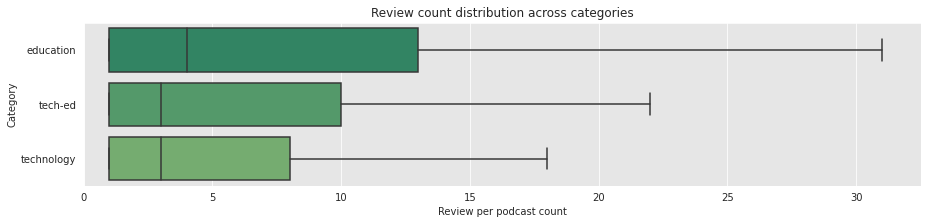

In [47]:
fig, ax = plt.subplots(figsize=(15, 3))
sns.boxplot(data=review_count_per_cat, x='review_count', y='category', showfliers = False, order=['education', 'tech-ed', 'technology'])
plt.xlim(0)

plot_labels('Review count distribution across categories', 'Review per podcast count', 'Category');

The plot above illustated the review count distribution across the categories. However, it omits outliers and only provides a zoomed in version of the boxplot for a clearerer comparison.

In [48]:
review_count_per_cat.groupby('category').describe()

review_count                                                   
                  count       mean        std  min  25%  50%   75%     max
category                                                                  
education        5110.0  22.915068  97.064417  1.0  1.0  4.0  13.0  4335.0
tech-ed           224.0  12.250000  27.712327  1.0  1.0  3.0  10.0   259.0
technology       2104.0  15.597909  68.041839  1.0  1.0  3.0   8.0  2067.0

Out of all the podcasts that have either *technology* or *education* as their assigned category:

* 5 110 podcasts are only in __*education*__ collecting a mean of 22.91 reviews per podcast. The IQR for reviews per podcast is 1-13 with a mode of 4 reviews per poodcast. All of these parameters are highest in this category compared to other options.
* 224 podcasts are in __*both categories*__ and collect 12.25 reviews per podcast on average. The IQR for reviews per podcast is 1-10 with a mode of 3 reviews per poodcast.
* 2 104 podcasts are only in __*technology*__ category collecting 15.6 reviews per podcast on average. The IQR for reviews per podcast is 1-8 (slightly lower than for both categories) with a mode of 3 reviews per podcast (same as for both categories).

### Treating outliers

The average reviews per podcast rate is highest in the _education_ category, however, mean is the central tendency measure most sensitive to outliers. To get a better understanding of the differences in means across the categories, a better look at the outliers may be needed.

In [49]:
outliers_summary = pd.DataFrame()
tech_ed_rev_count = pd.DataFrame()

for cat in review_count_per_cat.category.unique():
    temp_review_count = review_count_per_cat[review_count_per_cat.category == cat]
    total_podcasts = len(temp_review_count)
    temp_review_count = drop_outliers(temp_review_count)
    outlier_count = temp_review_count.isna().sum().review_count
    outlier_percentage = outlier_count / total_podcasts
    temp_summary = {
        'Category' : cat, 
        'Total count': '{:.0f}'.format(total_podcasts), 
        'Outlier count' : '{:.0f}'.format(outlier_count), 
        'Percentage of total' : '{:.2%}'.format(outlier_percentage)
        }

    outliers_summary = outliers_summary.append(temp_summary, ignore_index=True)
    tech_ed_rev_count = pd.concat([tech_ed_rev_count, temp_review_count.dropna()])

In [50]:
outliers_summary

,Category,Total count,Outlier count,Percentage of total
0,education,5110,661,12.94%
1,technology,2104,288,13.69%
2,tech-ed,224,31,13.84%


All three categories have about 13% of their data fall out of the norm. _Education_ category is the most populat yet also has the highest outlier count (661 outliers vs. 288 and 31 in _technology_ and _tech-ed_ respectively). 

Since the case of our investigation is a launch of a new podcast, it is safe to assume that just yet it may not have the recognition to receive abnormally high review counts. Thus, the outliers will be dropped.


In [51]:
# drop outliers entirely
tech_ed_rev_count = tech_ed_rev_count[tech_ed_rev_count.review_count.notna()]

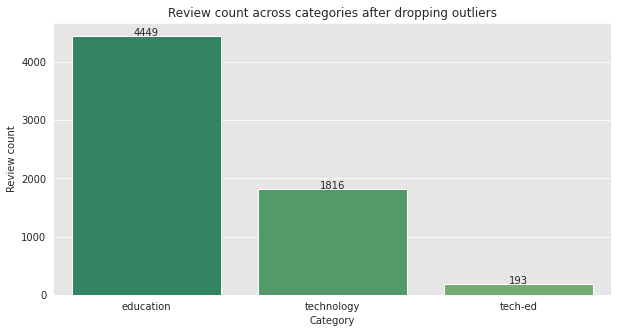

In [52]:
fig, ax= plt.subplots(figsize=(10, 5))
rev_per_cat_plot = sns.countplot(x='category', data=tech_ed_rev_count)
show_values(rev_per_cat_plot, orient='v', space=1, decimals=0)
plot_labels('Review count across categories after dropping outliers', 'Category', 'Review count');

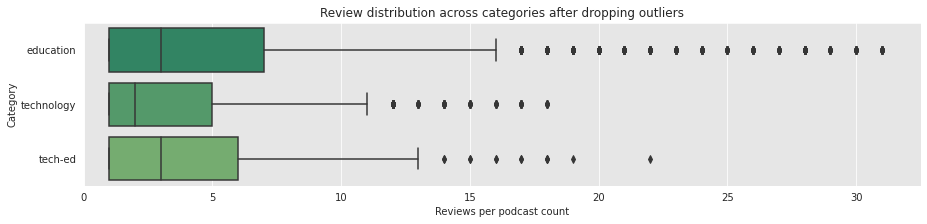

In [53]:
fig, ax = plt.subplots(figsize=(15, 3))
sns.boxplot(data=tech_ed_rev_count, x='review_count', y='category', showfliers = True)
plt.xlim(0)

plot_labels('Review distribution across categories after dropping outliers', 'Reviews per podcast count', 'Category');

In [54]:
rev_count_stats = tech_ed_rev_count.groupby('category').describe().reindex(['education', 'technology', 'tech-ed'])
rev_count_stats

review_count                                              
                  count      mean       std  min  25%  50%  75%   max
category                                                             
education        4449.0  5.772533  6.602945  1.0  1.0  3.0  7.0  31.0
technology       1816.0  3.675661  3.703915  1.0  1.0  2.0  5.0  18.0
tech-ed           193.0  4.279793  4.451645  1.0  1.0  3.0  6.0  22.0

Once the outliers were dropped, the means were reduced and so were all the other parameters. 

_Technology_ category while has more podcasts assigned than _technology_+_education_, on average received less reviews per podcasts and lowest maximum review count.

## Difference in mean review count
*Is the difference in mean review per podcast count significant between podcasts assigned to only technology, only education and both categories?*

**Population**: Podcasts, assigned to either _technology_ or _education_ categories.

**Parameter of Interest (μ<sub>1</sub> - μ<sub>2</sub>)**: mean review per podcast count

**Null Hypothesis**: μ<sub>1</sub> - μ<sub>2</sub> = 0; there is no difference in mean review per podcast count

**Alternative Hypothesis**: μ<sub>1</sub> - μ<sub>2</sub> ≠ 0; there is a significant difference in mean review per podcast count

**Significance level**: 5%; if the p-value calculated is smaller than 0.05, we reject the null hypothesis.

### Check Assumptions


* Samples are considered simple random samples (assuming that yes)
* Samples are independent from one another (yes, podcasts are filtered based on their assignment to only one or both categories)
* Samples are normally distributed
* Sample size is large enough

If the distributions of our samples are approximately normal or the sample size is large enough, the test statistic will be approximately normal too.

### Calculate test statistic

#### Confidence intervals

To determine which CI approach to use, we first have to comparre variances:

In [55]:
rev_count_stats['review_count']['std'].apply(lambda x: x*x)

category
education     43.598877
technology    13.718989
tech-ed       19.817142
Name: std, dtype: float64

From this data we can choose the **unpooled approach** - the assumption is that variances are not simmilar.

To construct the CI, we take _the difference in sample means ± estimated standard error · t* multiplier_

The _t*_ at 95% confidence level is 1.96.

In [56]:
mean_count_ci = pd.DataFrame()
categ = ['education', 'tech-ed', 'technology']
for ind in range(2):
    x1 = tech_ed_rev_count[tech_ed_rev_count.category == categ[ind]].review_count
    x2 = tech_ed_rev_count[tech_ed_rev_count.category == categ[ind+1]].review_count
    avg_difference = x1.mean() - x2.mean()
    best_estimate, margin, lower_bound, upper_bound = unpooled_ci(x1, x2, avg_difference)
        
    temp_mean_ci = pd.DataFrame({'difference in means': best_estimate, 'margin': margin, 'lower bound':lower_bound, 'upper bound':upper_bound}, index=[f'{categ[ind]} vs {categ[ind+1]}'])
    mean_count_ci = pd.concat([mean_count_ci, temp_mean_ci])

mean_count_ci

,difference in means,margin,lower bound,upper bound
education vs tech-ed,1.492740,0.657343,0.835397,2.150084
tech-ed vs technology,0.604132,0.650750,-0.046618,1.254881


With 95% cnfidence, the difference in mean review per podcast count between _education_ and _technology_+_education_ podcasts is estimated to be between __0.84 and 2.15__.

__95% confidence__: if this procedure were repeated multiple times, we would expect 95% of those resulting intervals to contain the difference in mean review count.


With 95% cnfidence, the difference in mean review per podcast count between _technology_+_education_ and _technology_ podcasts is estimated to be between __-0.5 and 1.25__. In this case, the interval includes zero, meaning there is a good chance that if the experiment is run again, there is a good chance of finding no difference between these groups.

#### T-test

Because the variance and sample sizes are different for each category, we will use a Welch's t-test instead of a Student t-test to account for this fact.

In [57]:
mean_count_ztest = pd.DataFrame()
categ = ['education', 'tech-ed', 'technology']
for ind in range(2):
    x1 = tech_ed_rev_count[tech_ed_rev_count.category == categ[ind]].review_count
    x2 = tech_ed_rev_count[tech_ed_rev_count.category == categ[ind+1]].review_count
    avg_difference = x1.mean() - x2.mean()
    tstat, pvalue, df = sm.ttest_ind(x1, x2, usevar='unequal')
        
    temp_ztest = pd.DataFrame({'difference in means': avg_difference, 'z-score':tstat, 'p-value':pvalue}, index=[f'{categ[ind]} vs {categ[ind+1]}'])
    mean_count_ztest = pd.concat([mean_count_ztest, temp_ztest])

mean_count_ztest

,difference in means,z-score,p-value
education vs tech-ed,1.492740,4.450904,0.000013
tech-ed vs technology,0.604132,1.819592,0.070173


The difference between mean reviews per _education_ podcasts and _tech-ed_ podcasts is 1.49 which is a statistically significant difference. P-value is less than 0.05, thus we reject the null hypothesis.

On the other hand, the difference between _tech-ed_ and _technology_ podcast mean reviews is 0.6 which is not statistically significant. P-value is more than 0.05, thus we fail to reject the null hypothesis.

___________________________________

Should we based our decision about categorizing the new podcast based on the reviews per podcast, **_education_ category would be the most suitable choice** as these types of podcasts receive significantly more reviews per podcast on average than podcast categorized as _education_+_technology_ or just _technology_. Such decision may imply that our podcast would attact more listeners.



## Review ratings

As mentioned before, when deciding what category to choose, we want to look not only at the mean review count per podcast, but also at the rating podcasts in each category receive.

In [58]:
mean_id_rating = tech_ed_reviews.groupby(['podcast_id']).mean()
mean_rating_cat = tech_ed_reviews[['podcast_id', 'category']].drop_duplicates(['podcast_id']).merge(mean_id_rating, how='inner', left_on='podcast_id', right_on='podcast_id')

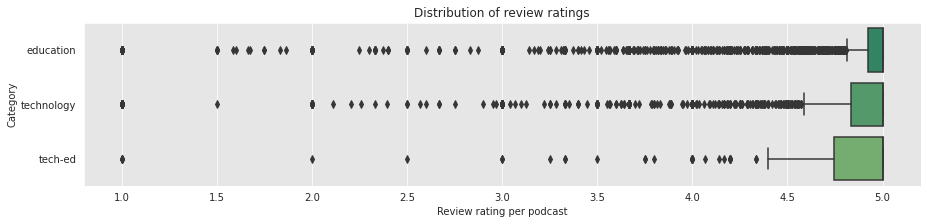

In [59]:
fig, ax = plt.subplots(figsize=(15, 3))
sns.boxplot(data=mean_rating_cat, x='rating', y='category')

plot_labels('Distribution of review ratings', 'Review rating per podcast', 'Category');

In [60]:
mean_rating_cat.groupby(['category']).describe().reindex(['education', 'technology', 'tech-ed'])

rating                                                  
             count      mean       std  min       25%  50%  75%  max
category                                                            
education   5110.0  4.774093  0.629783  1.0  4.924801  5.0  5.0  5.0
technology  2104.0  4.710968  0.704796  1.0  4.833333  5.0  5.0  5.0
tech-ed      224.0  4.710420  0.679641  1.0  4.747024  5.0  5.0  5.0

When comparing ratings across categories, the mean and standard deviation are very simmilar in all three cases. 

The IQR is the narrowest for _education_ and the widest for _technology_+_education_, suggesting that the majority of data in the latter is more spread out.

___________________________________

When analyzing ratings, a podcast with a single review may not provide a lot of insight. Thus, we will be analysing ratings for podcasts with at least 5 reviews.

In [61]:
ratings_rev_count = tech_ed_rev_count.merge(mean_rating_cat)

In [62]:
popular_pods = ratings_rev_count[ratings_rev_count.review_count > 5]

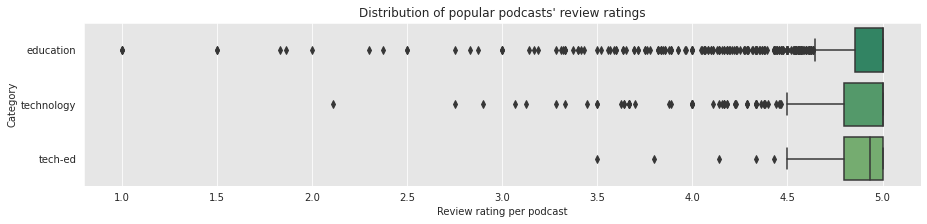

In [63]:
fig, ax = plt.subplots(figsize=(15, 3))
sns.boxplot(data=popular_pods, x='rating', y='category')

plot_labels("Distribution of popular podcasts' review ratings", 'Review rating per podcast', 'Category');

In [64]:
popular_pods.groupby('category').describe().rating.reindex(['education', 'technology', 'tech-ed'])

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
education,1460.0,4.822732,0.433312,1.000000,4.857143,5.000000,5.0,5.0
technology,371.0,4.783768,0.417021,2.111111,4.800000,5.000000,5.0,5.0
tech-ed,50.0,4.811817,0.317381,3.500000,4.800000,4.935417,5.0,5.0


The distribution of the more popular podcasts (those with review count over 5) shows a very similar mean across all three categories (approx 4.8). The IQR is also almost the same in all three categories. However, _education_ category still contains podcasts with mean rating of 1.0, while other two categories do not.

In [65]:
top_rating_data = []
bottom_rating_data = []
top_rating_perc = []

for cat in categ:
    category_ratings = popular_pods[(popular_pods.category == cat)]
    top_rating_pods = len(category_ratings[category_ratings.rating==5])
    top_rating_data.append(top_rating_pods)
    bottom_rating_data.append(len(category_ratings)-top_rating_pods)
    top_rating_perc.append(top_rating_pods/len(category_ratings))

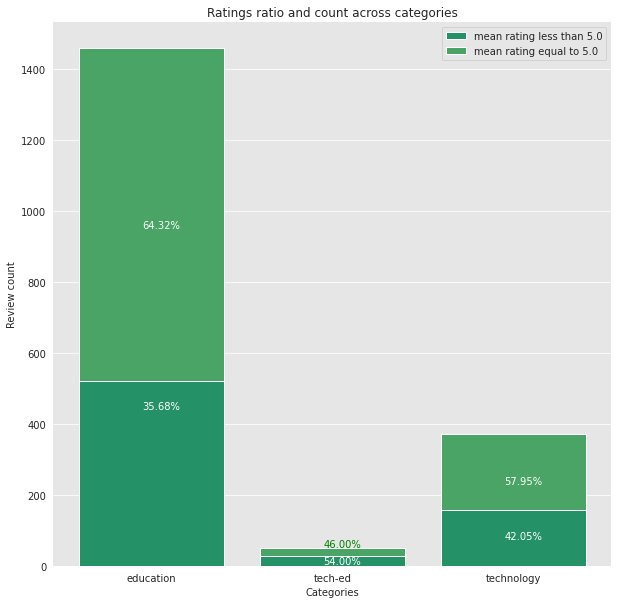

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.bar(categ, bottom_rating_data, label='mean rating less than 5.0')
ax.bar(categ, top_rating_data, label='mean rating equal to 5.0', bottom=bottom_rating_data)
plot_axes()
plot_labels('Ratings ratio and count across categories', 'Categories', 'Review count')

for i in range(len(categ)):
    if i != 1:
        plt.text(i-0.05,top_rating_data[i]+15, '{:.2%}'.format(top_rating_perc[i]), c='w')
        plt.text(i-0.05,bottom_rating_data[i]-80, '{:.2%}'.format(1-top_rating_perc[i]), c='w')
    else:
        plt.text(i-0.05,top_rating_data[i]+30, '{:.2%}'.format(top_rating_perc[i]), c='g')
        plt.text(i-0.05,bottom_rating_data[i]-23, '{:.2%}'.format(1-top_rating_perc[i]), c='w')        
plt.legend();

## Difference in rating proportions
*Is the difference in proportion of mean 5.0 star rating significant across the three categories for podcasts with more than 5 reviews?*

**Population**: Podcasts, assigned to either _technology_ or _education_ categories that received more than 5 reviews.

**Parameter of Interest (p<sub>1</sub> - p<sub>2</sub>)**: difference in 5.0 star rating population proportions

**Null Hypothesis**: p<sub>1</sub> - p<sub>2</sub> = 0; there is no difference in 5.0 rating population proportions across categories

**Alternative Hypothesis**: p<sub>1</sub> - p<sub>2</sub> ≠ 0; there is a significant difference in 5.0 rating population proportions across categories

**Significance level**: 5%; if the p-value calculated is smaller than 0.05, we reject the null hypothesis.

In [67]:
pop_proportions_data = pd.DataFrame()
for i in range(len(categ)):
    sample_size = top_rating_data[i] + bottom_rating_data[i]
    temp_data = pd.DataFrame({'category':categ[i],'sample size':sample_size, 'success count':top_rating_data[i], 'population_proportion':top_rating_perc[i]},index=[categ[i]])
    pop_proportions_data = pd.concat([pop_proportions_data, temp_data])

pop_proportions_data = pop_proportions_data.sort_values('population_proportion', ascending=False)
pop_proportions_data

,category,sample size,success count,population_proportion
education,education,1460,939,0.643151
technology,technology,371,215,0.579515
tech-ed,tech-ed,50,23,0.460000


When comapring population proportions, we will look if the 5.0 rating podcast proportion in _education_ category is significantly different from the one in _technology_ category. Similarly, we will look whether the 5.0 rating podcast proportion in _technology_ is significantly different than the one in _technology_+_education_.

### Check Assumptions


* Samples are considered simple random samples (assuming that yes)
* Samples are independent from one another (yes, podcasts are filtered based on their assignment to only one or both categories)
* Samples are normally distributed
* Sample size is large enough


### Calculate test statistic

In [68]:
pop_proportions_data.population_proportion

education     0.643151
technology    0.579515
tech-ed       0.460000
Name: population_proportion, dtype: float64

#### Confidence intervals

In [101]:
proportions_ci = pd.DataFrame()
categ = pop_proportions_data.index
for i in range(2):
    cat1 = pop_proportions_data.index[i]
    cat2 = pop_proportions_data.index[i+1]
    p1 = pop_proportions_data.population_proportion[cat1]
    p2 = pop_proportions_data.population_proportion[cat2]
    count1 = pop_proportions_data['success count'][cat1]
    count2 = pop_proportions_data['success count'][cat2]
    n1 = pop_proportions_data['sample size'][cat1]
    n2 = pop_proportions_data['sample size'][cat2]
    low, upp = confint_proportions_2indep(count1, n1, count2, n2)
    temp_ci = pd.DataFrame({'porportion difference': p1-p2, 'lower bound':low, 'upper bound':upp}, index=[f'{categ[i]} vs {categ[i+1]}'])
    proportions_ci=pd.concat([proportions_ci, temp_ci])

proportions_ci

,porportion difference,lower bound,upper bound
education vs technology,0.063636,0.008517,0.119887
technology vs tech-ed,0.119515,-0.025672,0.258785
